## Load Data

In [2]:
!nvidia-smi #py 3.10.11

ERROR: Option #py is not recognized. Please run 'nvidia-smi -h'.



In [3]:
#Count data
import os

# Define the paths to the directories
train_dir = "./../../data/train/"
test_dir = "./../../data/test/"

categories = [
    "ALGAL_LEAF_SPOT",
    "ALLOCARIDARA_ATTACK",
    "HEALTHY_LEAF",
    "LEAF_BLIGHT",
    "PHOMOPSIS_LEAF_SPOT"
]

print("--- Training Set File Counts ---")
for category in categories:
    dir_path = os.path.join(train_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

print("\n--- Test Set File Counts ---")
for category in categories:
    dir_path = os.path.join(test_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

--- Training Set File Counts ---
Number of files in ./../../data/train/ALGAL_LEAF_SPOT: 632
Number of files in ./../../data/train/ALLOCARIDARA_ATTACK: 787
Number of files in ./../../data/train/HEALTHY_LEAF: 841
Number of files in ./../../data/train/LEAF_BLIGHT: 808
Number of files in ./../../data/train/PHOMOPSIS_LEAF_SPOT: 757

--- Test Set File Counts ---
Number of files in ./../../data/test/ALGAL_LEAF_SPOT: 101
Number of files in ./../../data/test/ALLOCARIDARA_ATTACK: 126
Number of files in ./../../data/test/HEALTHY_LEAF: 135
Number of files in ./../../data/test/LEAF_BLIGHT: 129
Number of files in ./../../data/test/PHOMOPSIS_LEAF_SPOT: 121


# Install Timm

In [4]:
# Install Timm (Need to restart the runtime after finish install )
#pip install git+https://github.com/rwightman/pytorch-image-models.git
#%pip install lightning transformers datasets evaluate pillow 

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import StratifiedKFold,KFold

from lightning.fabric import Fabric

from copy import copy

import shutil
import torchvision.transforms as transforms

from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets

## visualization Model

In [6]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [7]:
# Select model (List of available is shown above)
mobilenetv3_large_100 = "hf_hub:timm/mobilenetv3_large_100.miil_in21k_ft_in1k"
mobilenetv3_large_100_model= timm.create_model(mobilenetv3_large_100, pretrained=True, num_classes=5)
# Print a summary using torchinfo (uncomment for actual output)
summary(model=mobilenetv3_large_100_model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                          [16, 3, 224, 224]    [16, 5]              --                   True
├─Conv2d (conv_stem)                               [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
├─BatchNormAct2d (bn1)                             [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    └─Identity (drop)                             [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─Hardswish (act)                             [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
├─Sequential (blocks)                              [16, 16, 112, 112]   [16, 960, 7, 7]      --                   True
│    └─Sequential (0)                              [16, 16, 112, 112]   [16, 16, 112, 112]   --                   True
│    │    └─DepthwiseSeparableConv (0)         

In [8]:
# Transform image data based on ImageNet's mean and std
data_transforms = { # เปลี่ยนชื่อตัวแปรเป็น data_transforms
    "train": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
}

In [9]:
dataset = datasets.ImageFolder(root=train_dir,
                               transform=data_transforms["train"], 
                               target_transform=None)

In [10]:
dataset.class_to_idx

{'ALGAL_LEAF_SPOT': 0,
 'ALLOCARIDARA_ATTACK': 1,
 'HEALTHY_LEAF': 2,
 'LEAF_BLIGHT': 3,
 'PHOMOPSIS_LEAF_SPOT': 4}

In [11]:
len(dataset)

3825

In [12]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
#Select Model
model_name = "hf_hub:timm/mobilenetv3_large_100.miil_in21k_ft_in1k"

In [14]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("accuracy")

In [15]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [16]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 16
eval_batch_size = 8
num_accumulate = 1

In [17]:
torch.set_float32_matmul_precision('high')
#fabric = Fabric(accelerator="cuda", precision="16-mixed")
fabric = Fabric(accelerator="gpu", devices=1, precision="16-mixed")
fabric.launch()

Using 16-bit Automatic Mixed Precision (AMP)


In [18]:
import time

In [19]:
%%time
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of {k_splits}")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=5)


    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=5e-4)
    # optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)    # update the slow weight every k steps
                                                                   # update the optimizer by combine slow weight and fast weight * alpha

    model, optimizer = fabric.setup(model, optimizer)

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
        "best_val_loss": 999,
    }

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        ### === Train Loop === ###
        ## Time
        s1 = time.time()

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            # inputs = {k: v.to(device) for k,v in inputs.items()}
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            fabric.backward(loss)

            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
        ### ==================== ###

        # optimizer.sync_lookahead()              # Sync slow weight and fast weight
        scheduler.step(epoch + 1)

        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                # inputs = {k: v.to(device) for k,v in inputs.items()}
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###
        ## Time train finish
        s2 = time.time()
        elapsed_time = s2 - s1


        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets)["accuracy"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets)["accuracy"]

        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)

        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        if metric_val > info["best_metric_val"]:
        # if info["val_loss"][-1] < info["best_val_loss"]:
            print("New Best Score!")
            # print("New Best Val Loss")
            info["best_metric_val"] = metric_val
            # info["best_val_loss"] = info["val_loss"][-1]
            torch.save(model, f"mobilenetv3_large_100_checkpoint_fold{fold}.pt")

        print(f"Using time of Fold: {fold} | Epoch: {epoch} | {elapsed_time} second ")
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 0 | 38.33706283569336 second 
{'metric_train': [0.6516339869281046], 'metric_val': [0.807843137254902], 'train_loss': [np.float64(1.7201075774695103)], 'val_loss': [np.float64(0.7101186811360094)], 'best_metric_val': 0.807843137254902, 'best_val_loss': 999}
Fold: 0 | Epoch: 0 | Metric: 0.807843137254902 | Training Loss: 1.7201075774695103 | Validation Loss: 0.7101186811360094


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 1 | 34.97896361351013 second 
{'metric_train': [0.6516339869281046, 0.8849673202614379], 'metric_val': [0.807843137254902, 0.9084967320261438], 'train_loss': [np.float64(1.7201075774695103), np.float64(0.3941862369647424)], 'val_loss': [np.float64(0.7101186811360094), np.float64(0.3085011673623133)], 'best_metric_val': 0.9084967320261438, 'best_val_loss': 999}
Fold: 0 | Epoch: 1 | Metric: 0.9084967320261438 | Training Loss: 0.3941862369647424 | Validation Loss: 0.3085011673623133


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 0 | Epoch: 2 | 34.81597828865051 second 
{'metric_train': [0.6516339869281046, 0.8849673202614379, 0.9562091503267974], 'metric_val': [0.807843137254902, 0.9084967320261438, 0.8915032679738563], 'train_loss': [np.float64(1.7201075774695103), np.float64(0.3941862369647424), np.float64(0.1266357429949494)], 'val_loss': [np.float64(0.7101186811360094), np.float64(0.3085011673623133), np.float64(0.4478955633448957)], 'best_metric_val': 0.9084967320261438, 'best_val_loss': 999}
Fold: 0 | Epoch: 2 | Metric: 0.8915032679738563 | Training Loss: 0.1266357429949494 | Validation Loss: 0.4478955633448957


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 3 | 36.23348951339722 second 
{'metric_train': [0.6516339869281046, 0.8849673202614379, 0.9562091503267974, 0.9774509803921568], 'metric_val': [0.807843137254902, 0.9084967320261438, 0.8915032679738563, 0.9333333333333333], 'train_loss': [np.float64(1.7201075774695103), np.float64(0.3941862369647424), np.float64(0.1266357429949494), np.float64(0.06757551329554683)], 'val_loss': [np.float64(0.7101186811360094), np.float64(0.3085011673623133), np.float64(0.4478955633448957), np.float64(0.2522187257040211)], 'best_metric_val': 0.9333333333333333, 'best_val_loss': 999}
Fold: 0 | Epoch: 3 | Metric: 0.9333333333333333 | Training Loss: 0.06757551329554683 | Validation Loss: 0.2522187257040211


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 4 | 39.39793395996094 second 
{'metric_train': [0.6516339869281046, 0.8849673202614379, 0.9562091503267974, 0.9774509803921568, 0.9934640522875817], 'metric_val': [0.807843137254902, 0.9084967320261438, 0.8915032679738563, 0.9333333333333333, 0.9437908496732026], 'train_loss': [np.float64(1.7201075774695103), np.float64(0.3941862369647424), np.float64(0.1266357429949494), np.float64(0.06757551329554683), np.float64(0.01961837584328426)], 'val_loss': [np.float64(0.7101186811360094), np.float64(0.3085011673623133), np.float64(0.4478955633448957), np.float64(0.2522187257040211), np.float64(0.22737457934964725)], 'best_metric_val': 0.9437908496732026, 'best_val_loss': 999}
Fold: 0 | Epoch: 4 | Metric: 0.9437908496732026 | Training Loss: 0.01961837584328426 | Validation Loss: 0.22737457934964725
Fold 2 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 0 | 39.887617349624634 second 
{'metric_train': [0.6549019607843137], 'metric_val': [0.8614379084967321], 'train_loss': [np.float64(1.7852514496965644)], 'val_loss': [np.float64(0.51017780613923)], 'best_metric_val': 0.8614379084967321, 'best_val_loss': 999}
Fold: 1 | Epoch: 0 | Metric: 0.8614379084967321 | Training Loss: 1.7852514496965644 | Validation Loss: 0.51017780613923


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 1 | 40.944135427474976 second 
{'metric_train': [0.6549019607843137, 0.8954248366013072], 'metric_val': [0.8614379084967321, 0.9071895424836601], 'train_loss': [np.float64(1.7852514496965644), np.float64(0.35946088641806756)], 'val_loss': [np.float64(0.51017780613923), np.float64(0.3276356817586)], 'best_metric_val': 0.9071895424836601, 'best_val_loss': 999}
Fold: 1 | Epoch: 1 | Metric: 0.9071895424836601 | Training Loss: 0.35946088641806756 | Validation Loss: 0.3276356817586


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 2 | 42.07673263549805 second 
{'metric_train': [0.6549019607843137, 0.8954248366013072, 0.957843137254902], 'metric_val': [0.8614379084967321, 0.9071895424836601, 0.9215686274509803], 'train_loss': [np.float64(1.7852514496965644), np.float64(0.35946088641806756), np.float64(0.13034994952401271)], 'val_loss': [np.float64(0.51017780613923), np.float64(0.3276356817586), np.float64(0.3496201945891298)], 'best_metric_val': 0.9215686274509803, 'best_val_loss': 999}
Fold: 1 | Epoch: 2 | Metric: 0.9215686274509803 | Training Loss: 0.13034994952401271 | Validation Loss: 0.3496201945891298


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 3 | 35.75625491142273 second 
{'metric_train': [0.6549019607843137, 0.8954248366013072, 0.957843137254902, 0.9803921568627451], 'metric_val': [0.8614379084967321, 0.9071895424836601, 0.9215686274509803, 0.934640522875817], 'train_loss': [np.float64(1.7852514496965644), np.float64(0.35946088641806756), np.float64(0.13034994952401271), np.float64(0.05345902183690517)], 'val_loss': [np.float64(0.51017780613923), np.float64(0.3276356817586), np.float64(0.3496201945891298), np.float64(0.2766617647306489)], 'best_metric_val': 0.934640522875817, 'best_val_loss': 999}
Fold: 1 | Epoch: 3 | Metric: 0.934640522875817 | Training Loss: 0.05345902183690517 | Validation Loss: 0.2766617647306489


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 4 | 40.11794114112854 second 
{'metric_train': [0.6549019607843137, 0.8954248366013072, 0.957843137254902, 0.9803921568627451, 0.9931372549019608], 'metric_val': [0.8614379084967321, 0.9071895424836601, 0.9215686274509803, 0.934640522875817, 0.9424836601307189], 'train_loss': [np.float64(1.7852514496965644), np.float64(0.35946088641806756), np.float64(0.13034994952401271), np.float64(0.05345902183690517), np.float64(0.0192676049333708)], 'val_loss': [np.float64(0.51017780613923), np.float64(0.3276356817586), np.float64(0.3496201945891298), np.float64(0.2766617647306489), np.float64(0.23483910191155624)], 'best_metric_val': 0.9424836601307189, 'best_val_loss': 999}
Fold: 1 | Epoch: 4 | Metric: 0.9424836601307189 | Training Loss: 0.0192676049333708 | Validation Loss: 0.23483910191155624
Fold 3 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 0 | 38.727107524871826 second 
{'metric_train': [0.7081699346405229], 'metric_val': [0.8666666666666667], 'train_loss': [np.float64(1.586503178269292)], 'val_loss': [np.float64(0.44591711794267513)], 'best_metric_val': 0.8666666666666667, 'best_val_loss': 999}
Fold: 2 | Epoch: 0 | Metric: 0.8666666666666667 | Training Loss: 1.586503178269292 | Validation Loss: 0.44591711794267513


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 1 | 36.9154577255249 second 
{'metric_train': [0.7081699346405229, 0.8895424836601307], 'metric_val': [0.8666666666666667, 0.8901960784313725], 'train_loss': [np.float64(1.586503178269292), np.float64(0.42403610432544764)], 'val_loss': [np.float64(0.44591711794267513), np.float64(0.47115133663886394)], 'best_metric_val': 0.8901960784313725, 'best_val_loss': 999}
Fold: 2 | Epoch: 1 | Metric: 0.8901960784313725 | Training Loss: 0.42403610432544764 | Validation Loss: 0.47115133663886394


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 2 | 41.899171352386475 second 
{'metric_train': [0.7081699346405229, 0.8895424836601307, 0.9526143790849673], 'metric_val': [0.8666666666666667, 0.8901960784313725, 0.9254901960784314], 'train_loss': [np.float64(1.586503178269292), np.float64(0.42403610432544764), np.float64(0.15711878366088664)], 'val_loss': [np.float64(0.44591711794267513), np.float64(0.47115133663886394), np.float64(0.27045375133489813)], 'best_metric_val': 0.9254901960784314, 'best_val_loss': 999}
Fold: 2 | Epoch: 2 | Metric: 0.9254901960784314 | Training Loss: 0.15711878366088664 | Validation Loss: 0.27045375133489813


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 3 | 38.6335563659668 second 
{'metric_train': [0.7081699346405229, 0.8895424836601307, 0.9526143790849673, 0.9839869281045751], 'metric_val': [0.8666666666666667, 0.8901960784313725, 0.9254901960784314, 0.9294117647058824], 'train_loss': [np.float64(1.586503178269292), np.float64(0.42403610432544764), np.float64(0.15711878366088664), np.float64(0.04595672688712208)], 'val_loss': [np.float64(0.44591711794267513), np.float64(0.47115133663886394), np.float64(0.27045375133489813), np.float64(0.28633785182405)], 'best_metric_val': 0.9294117647058824, 'best_val_loss': 999}
Fold: 2 | Epoch: 3 | Metric: 0.9294117647058824 | Training Loss: 0.04595672688712208 | Validation Loss: 0.28633785182405


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 4 | 38.659544467926025 second 
{'metric_train': [0.7081699346405229, 0.8895424836601307, 0.9526143790849673, 0.9839869281045751, 0.9915032679738562], 'metric_val': [0.8666666666666667, 0.8901960784313725, 0.9254901960784314, 0.9294117647058824, 0.9398692810457516], 'train_loss': [np.float64(1.586503178269292), np.float64(0.42403610432544764), np.float64(0.15711878366088664), np.float64(0.04595672688712208), np.float64(0.021615566683256777)], 'val_loss': [np.float64(0.44591711794267513), np.float64(0.47115133663886394), np.float64(0.27045375133489813), np.float64(0.28633785182405), np.float64(0.26056593186145705)], 'best_metric_val': 0.9398692810457516, 'best_val_loss': 999}
Fold: 2 | Epoch: 4 | Metric: 0.9398692810457516 | Training Loss: 0.021615566683256777 | Validation Loss: 0.26056593186145705
Fold 4 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 0 | 37.48678684234619 second 
{'metric_train': [0.6696078431372549], 'metric_val': [0.8470588235294118], 'train_loss': [np.float64(1.9637798857778155)], 'val_loss': [np.float64(0.5214885681461965)], 'best_metric_val': 0.8470588235294118, 'best_val_loss': 999}
Fold: 3 | Epoch: 0 | Metric: 0.8470588235294118 | Training Loss: 1.9637798857778155 | Validation Loss: 0.5214885681461965


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 3 | Epoch: 1 | 34.20282435417175 second 
{'metric_train': [0.6696078431372549, 0.9091503267973856], 'metric_val': [0.8470588235294118, 0.8156862745098039], 'train_loss': [np.float64(1.9637798857778155), np.float64(0.32226420237384445)], 'val_loss': [np.float64(0.5214885681461965), np.float64(0.7952012434156996)], 'best_metric_val': 0.8470588235294118, 'best_val_loss': 999}
Fold: 3 | Epoch: 1 | Metric: 0.8156862745098039 | Training Loss: 0.32226420237384445 | Validation Loss: 0.7952012434156996


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 2 | 34.20620274543762 second 
{'metric_train': [0.6696078431372549, 0.9091503267973856, 0.9516339869281045], 'metric_val': [0.8470588235294118, 0.8156862745098039, 0.8967320261437909], 'train_loss': [np.float64(1.9637798857778155), np.float64(0.32226420237384445), np.float64(0.16609659019117848)], 'val_loss': [np.float64(0.5214885681461965), np.float64(0.7952012434156996), np.float64(0.4089283289511198)], 'best_metric_val': 0.8967320261437909, 'best_val_loss': 999}
Fold: 3 | Epoch: 2 | Metric: 0.8967320261437909 | Training Loss: 0.16609659019117848 | Validation Loss: 0.4089283289511198


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 3 | 34.41342854499817 second 
{'metric_train': [0.6696078431372549, 0.9091503267973856, 0.9516339869281045, 0.984640522875817], 'metric_val': [0.8470588235294118, 0.8156862745098039, 0.8967320261437909, 0.9215686274509803], 'train_loss': [np.float64(1.9637798857778155), np.float64(0.32226420237384445), np.float64(0.16609659019117848), np.float64(0.05755282257403375)], 'val_loss': [np.float64(0.5214885681461965), np.float64(0.7952012434156996), np.float64(0.4089283289511198), np.float64(0.2787589781713062)], 'best_metric_val': 0.9215686274509803, 'best_val_loss': 999}
Fold: 3 | Epoch: 3 | Metric: 0.9215686274509803 | Training Loss: 0.05755282257403375 | Validation Loss: 0.2787589781713062


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 3 | Epoch: 4 | 36.370020389556885 second 
{'metric_train': [0.6696078431372549, 0.9091503267973856, 0.9516339869281045, 0.984640522875817, 0.9915032679738562], 'metric_val': [0.8470588235294118, 0.8156862745098039, 0.8967320261437909, 0.9215686274509803, 0.9215686274509803], 'train_loss': [np.float64(1.9637798857778155), np.float64(0.32226420237384445), np.float64(0.16609659019117848), np.float64(0.05755282257403375), np.float64(0.026207323350462275)], 'val_loss': [np.float64(0.5214885681461965), np.float64(0.7952012434156996), np.float64(0.4089283289511198), np.float64(0.2787589781713062), np.float64(0.27591708040414414)], 'best_metric_val': 0.9215686274509803, 'best_val_loss': 999}
Fold: 3 | Epoch: 4 | Metric: 0.9215686274509803 | Training Loss: 0.026207323350462275 | Validation Loss: 0.27591708040414414
Fold 5 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 0 | 34.22335457801819 second 
{'metric_train': [0.6630718954248366], 'metric_val': [0.807843137254902], 'train_loss': [np.float64(1.7641946451282517)], 'val_loss': [np.float64(0.733019705968521)], 'best_metric_val': 0.807843137254902, 'best_val_loss': 999}
Fold: 4 | Epoch: 0 | Metric: 0.807843137254902 | Training Loss: 1.7641946451282517 | Validation Loss: 0.733019705968521


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 1 | 34.37931823730469 second 
{'metric_train': [0.6630718954248366, 0.8754901960784314], 'metric_val': [0.807843137254902, 0.8496732026143791], 'train_loss': [np.float64(1.7641946451282517), np.float64(0.45524476276841597)], 'val_loss': [np.float64(0.733019705968521), np.float64(0.540046182447289)], 'best_metric_val': 0.8496732026143791, 'best_val_loss': 999}
Fold: 4 | Epoch: 1 | Metric: 0.8496732026143791 | Training Loss: 0.45524476276841597 | Validation Loss: 0.540046182447289


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 2 | 34.87785005569458 second 
{'metric_train': [0.6630718954248366, 0.8754901960784314, 0.9405228758169935], 'metric_val': [0.807843137254902, 0.8496732026143791, 0.8797385620915033], 'train_loss': [np.float64(1.7641946451282517), np.float64(0.45524476276841597), np.float64(0.20409930198608586)], 'val_loss': [np.float64(0.733019705968521), np.float64(0.540046182447289), np.float64(0.5521348552971782)], 'best_metric_val': 0.8797385620915033, 'best_val_loss': 999}
Fold: 4 | Epoch: 2 | Metric: 0.8797385620915033 | Training Loss: 0.20409930198608586 | Validation Loss: 0.5521348552971782


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 3 | 35.03545045852661 second 
{'metric_train': [0.6630718954248366, 0.8754901960784314, 0.9405228758169935, 0.9745098039215686], 'metric_val': [0.807843137254902, 0.8496732026143791, 0.8797385620915033, 0.9163398692810457], 'train_loss': [np.float64(1.7641946451282517), np.float64(0.45524476276841597), np.float64(0.20409930198608586), np.float64(0.07559375907385402)], 'val_loss': [np.float64(0.733019705968521), np.float64(0.540046182447289), np.float64(0.5521348552971782), np.float64(0.28170017307742157)], 'best_metric_val': 0.9163398692810457, 'best_val_loss': 999}
Fold: 4 | Epoch: 3 | Metric: 0.9163398692810457 | Training Loss: 0.07559375907385402 | Validation Loss: 0.28170017307742157


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 4 | 34.21068978309631 second 
{'metric_train': [0.6630718954248366, 0.8754901960784314, 0.9405228758169935, 0.9745098039215686, 0.9921568627450981], 'metric_val': [0.807843137254902, 0.8496732026143791, 0.8797385620915033, 0.9163398692810457, 0.930718954248366], 'train_loss': [np.float64(1.7641946451282517), np.float64(0.45524476276841597), np.float64(0.20409930198608586), np.float64(0.07559375907385402), np.float64(0.022728360594063208)], 'val_loss': [np.float64(0.733019705968521), np.float64(0.540046182447289), np.float64(0.5521348552971782), np.float64(0.28170017307742157), np.float64(0.26690218145547934)], 'best_metric_val': 0.930718954248366, 'best_val_loss': 999}
Fold: 4 | Epoch: 4 | Metric: 0.930718954248366 | Training Loss: 0.022728360594063208 | Validation Loss: 0.26690218145547934
CPU times: total: 45.5 s
Wall time: 15min 33s


In [20]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

Evaluating Fold 0:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


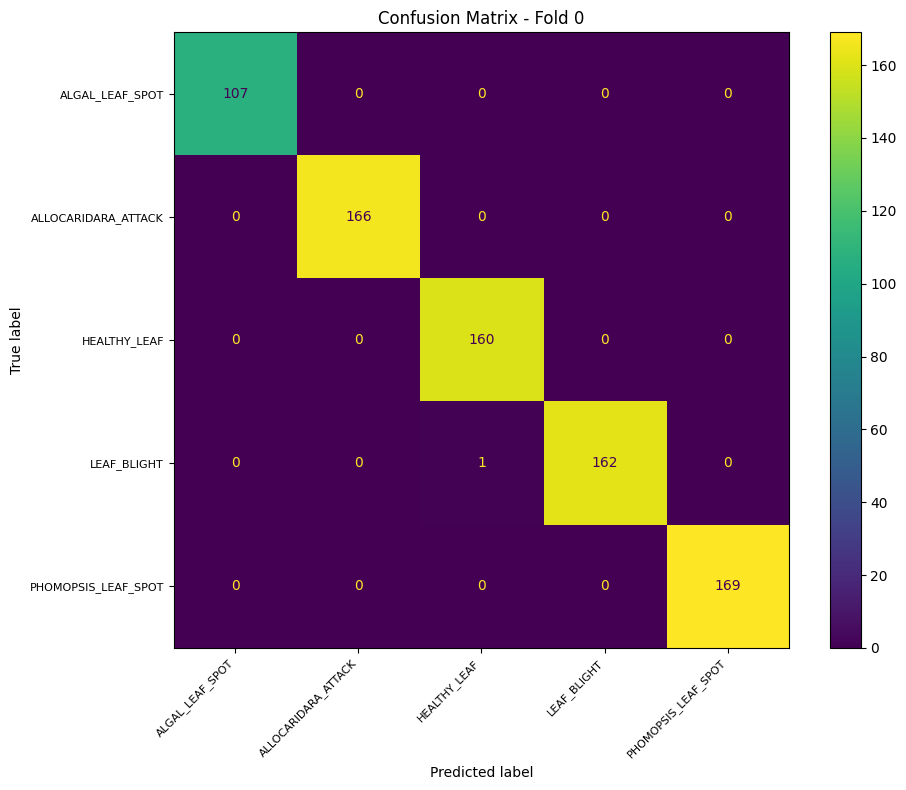

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       0.99      1.00      1.00       160
        LEAF_BLIGHT       1.00      0.99      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 1 ---


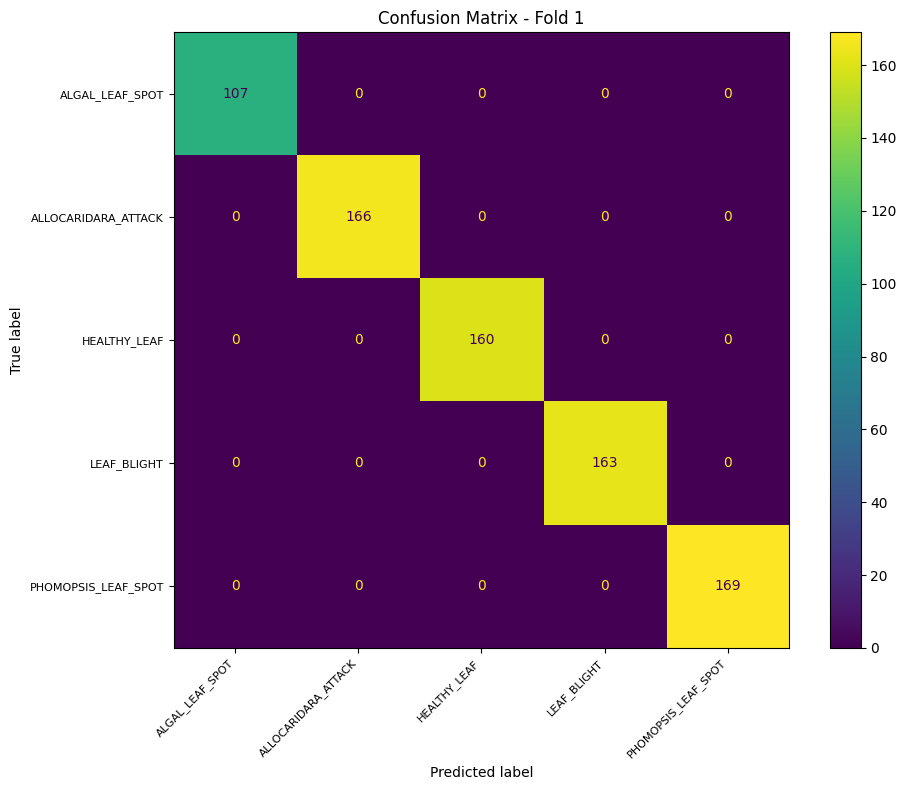

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 2 ---


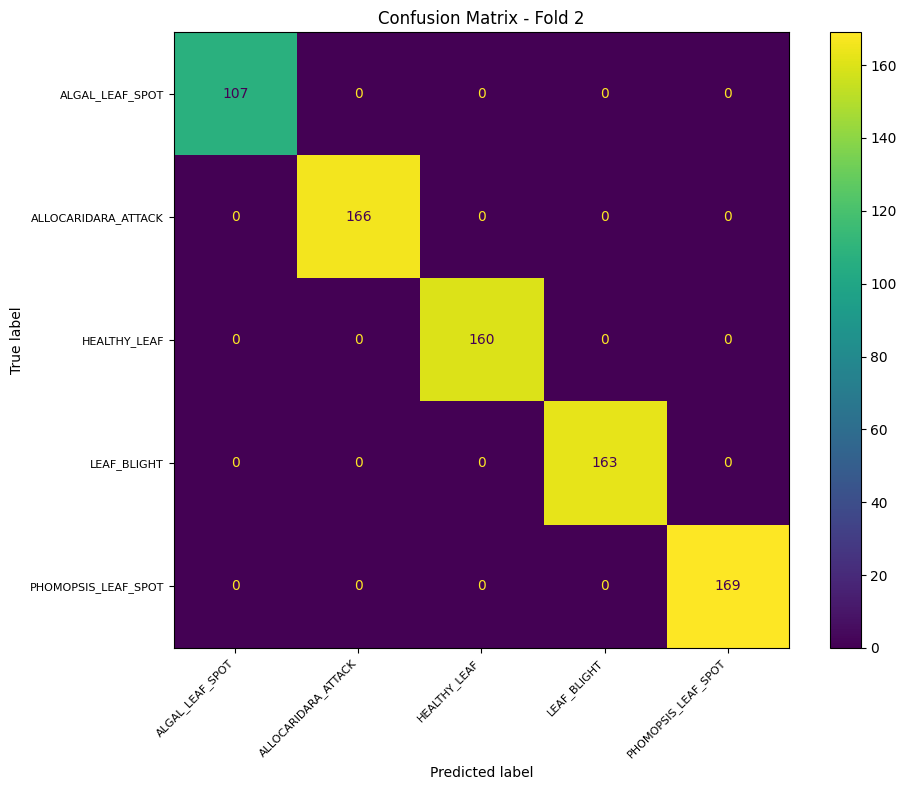

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 3 ---


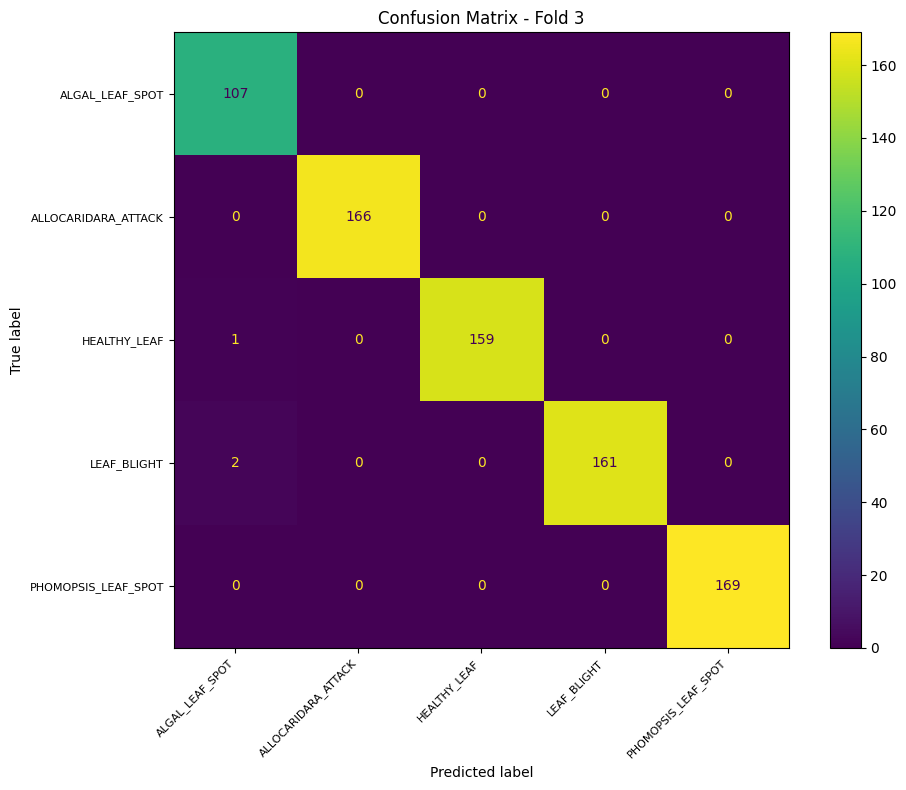

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.97      1.00      0.99       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      0.99      1.00       160
        LEAF_BLIGHT       1.00      0.99      0.99       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       0.99      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 4 ---


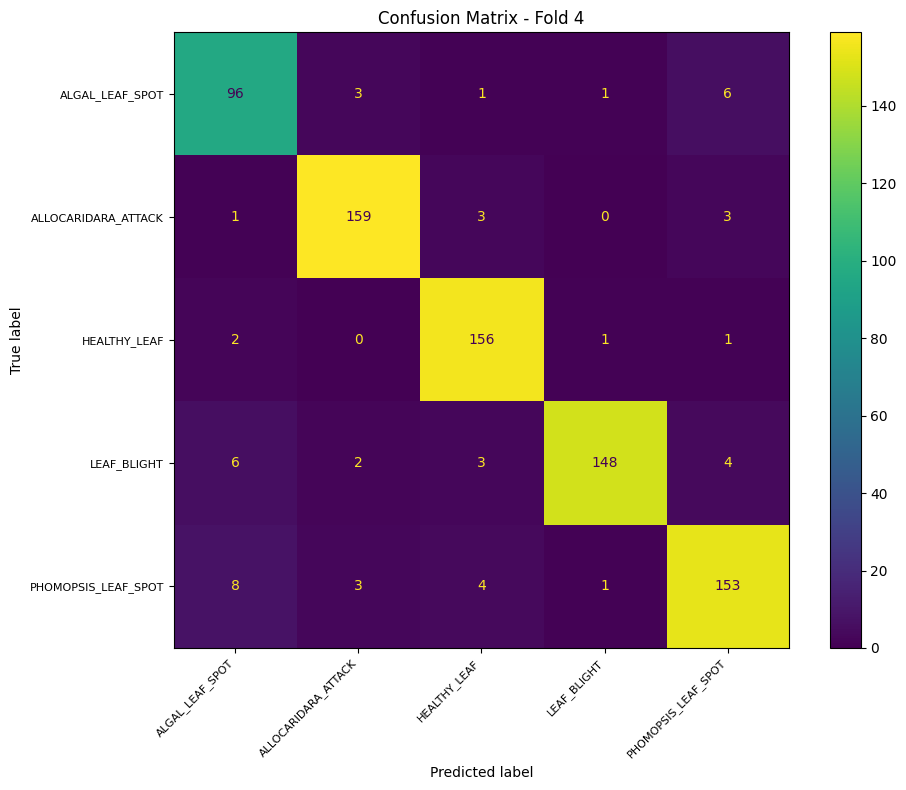

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.85      0.90      0.87       107
ALLOCARIDARA_ATTACK       0.95      0.96      0.95       166
       HEALTHY_LEAF       0.93      0.97      0.95       160
        LEAF_BLIGHT       0.98      0.91      0.94       163
PHOMOPSIS_LEAF_SPOT       0.92      0.91      0.91       169

           accuracy                           0.93       765
          macro avg       0.93      0.93      0.93       765
       weighted avg       0.93      0.93      0.93       765

--------------------------------------------------


In [21]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"mobilenetv3_large_100_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

In [22]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [23]:
# Making Dataset
test_dataset = datasets.ImageFolder(root=test_dir,
                               transform=data_transforms["test"], # ใช้ data_transforms แทน
                               target_transform=None)# transforms to perform on labels (if necessary)

In [24]:
len(test_dataset)

612

In [25]:
# Making test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [26]:
test_dataset.classes

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [27]:
len(test_dataloader)

77

Evaluating Fold 0:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


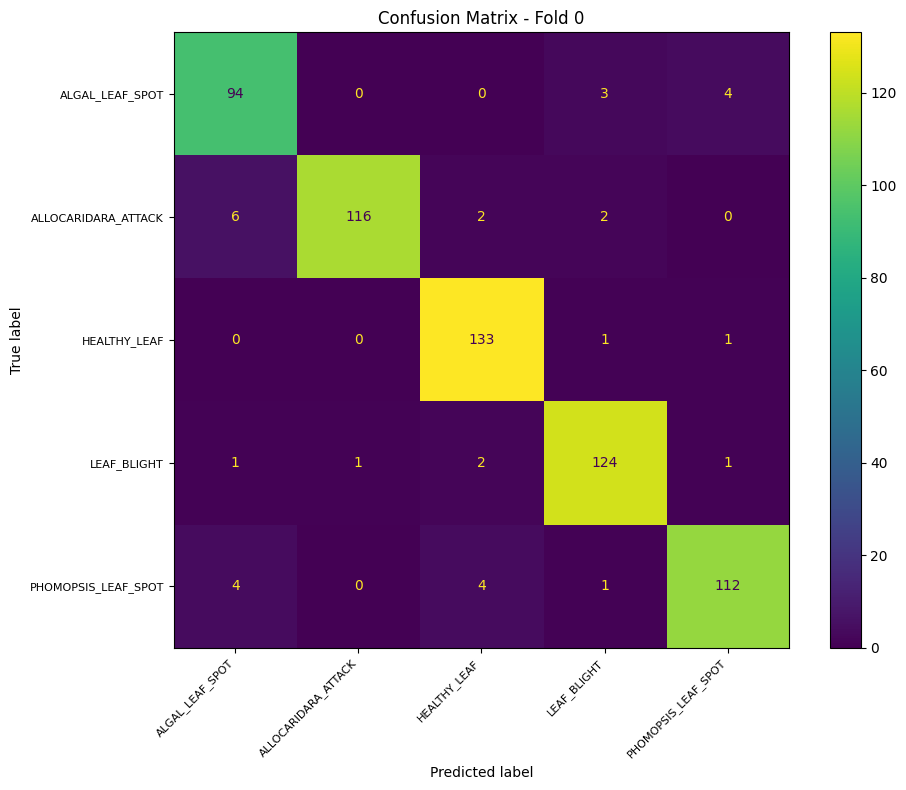

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.90      0.93      0.91       101
ALLOCARIDARA_ATTACK       0.99      0.92      0.95       126
       HEALTHY_LEAF       0.94      0.99      0.96       135
        LEAF_BLIGHT       0.95      0.96      0.95       129
PHOMOPSIS_LEAF_SPOT       0.95      0.93      0.94       121

           accuracy                           0.95       612
          macro avg       0.95      0.94      0.94       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 1 ---


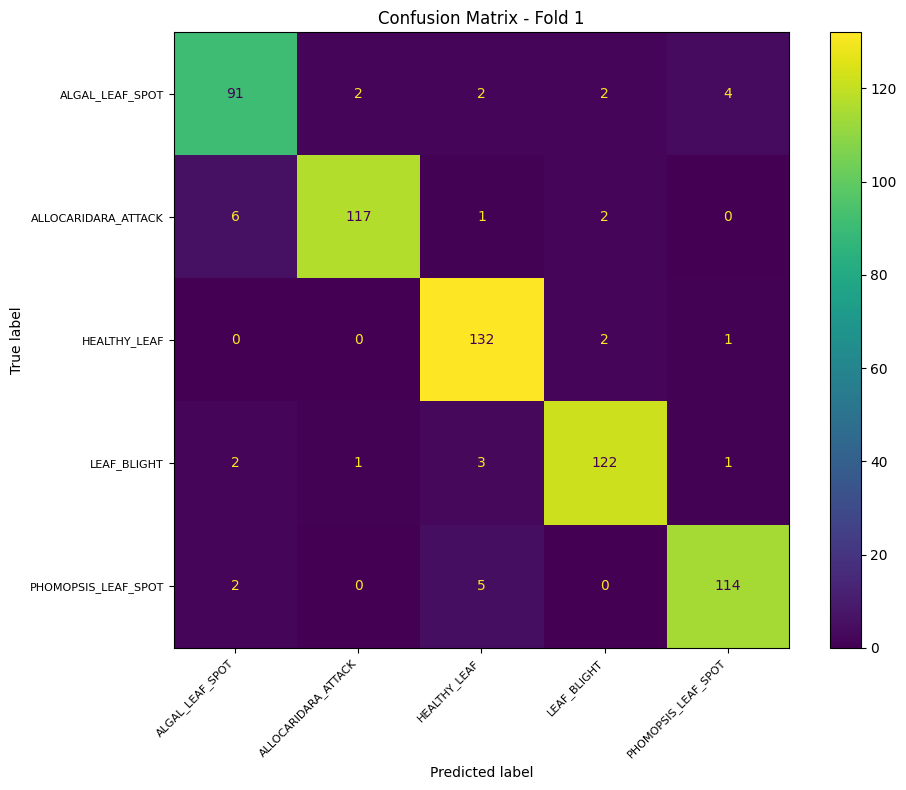

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.90      0.90      0.90       101
ALLOCARIDARA_ATTACK       0.97      0.93      0.95       126
       HEALTHY_LEAF       0.92      0.98      0.95       135
        LEAF_BLIGHT       0.95      0.95      0.95       129
PHOMOPSIS_LEAF_SPOT       0.95      0.94      0.95       121

           accuracy                           0.94       612
          macro avg       0.94      0.94      0.94       612
       weighted avg       0.94      0.94      0.94       612

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 2 ---


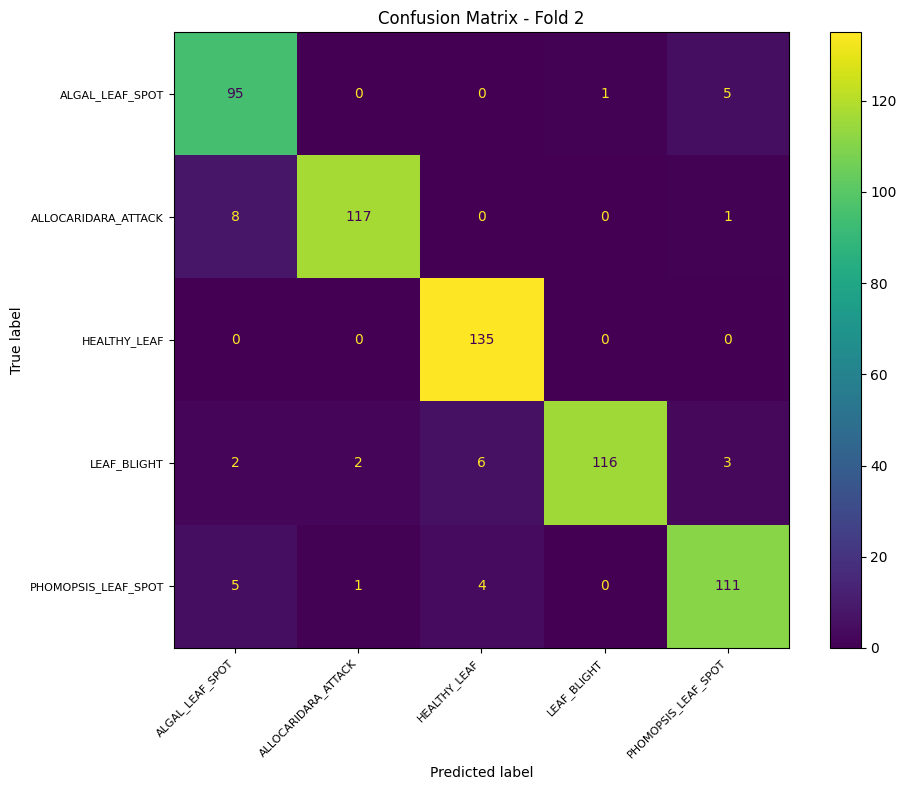

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.86      0.94      0.90       101
ALLOCARIDARA_ATTACK       0.97      0.93      0.95       126
       HEALTHY_LEAF       0.93      1.00      0.96       135
        LEAF_BLIGHT       0.99      0.90      0.94       129
PHOMOPSIS_LEAF_SPOT       0.93      0.92      0.92       121

           accuracy                           0.94       612
          macro avg       0.94      0.94      0.94       612
       weighted avg       0.94      0.94      0.94       612

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 3 ---


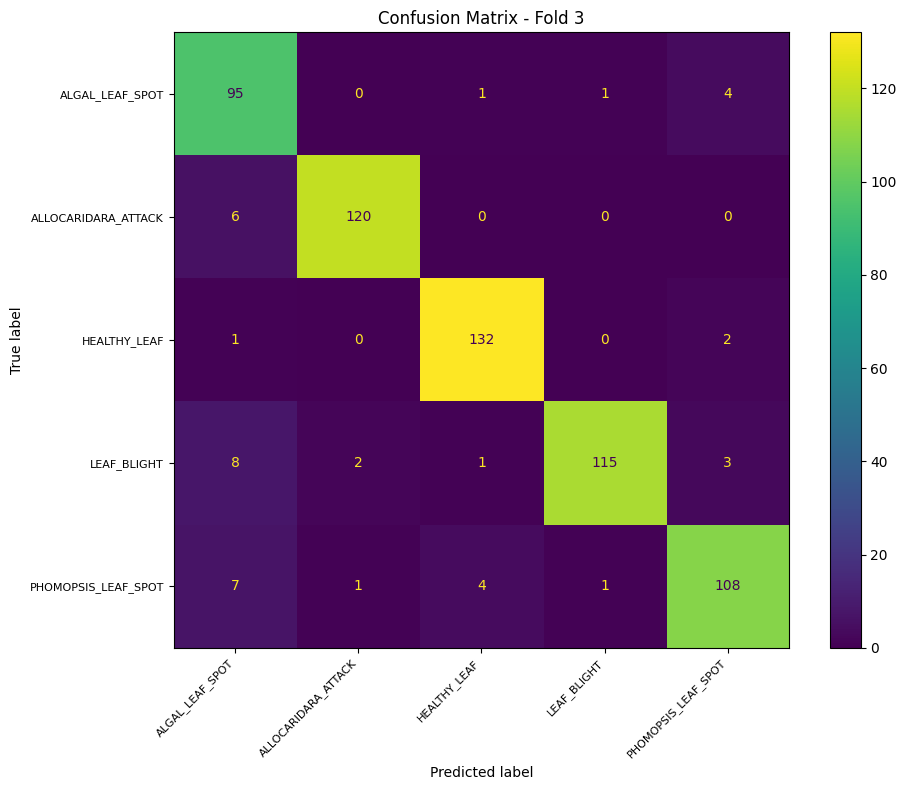

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.81      0.94      0.87       101
ALLOCARIDARA_ATTACK       0.98      0.95      0.96       126
       HEALTHY_LEAF       0.96      0.98      0.97       135
        LEAF_BLIGHT       0.98      0.89      0.93       129
PHOMOPSIS_LEAF_SPOT       0.92      0.89      0.91       121

           accuracy                           0.93       612
          macro avg       0.93      0.93      0.93       612
       weighted avg       0.94      0.93      0.93       612

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 4 ---


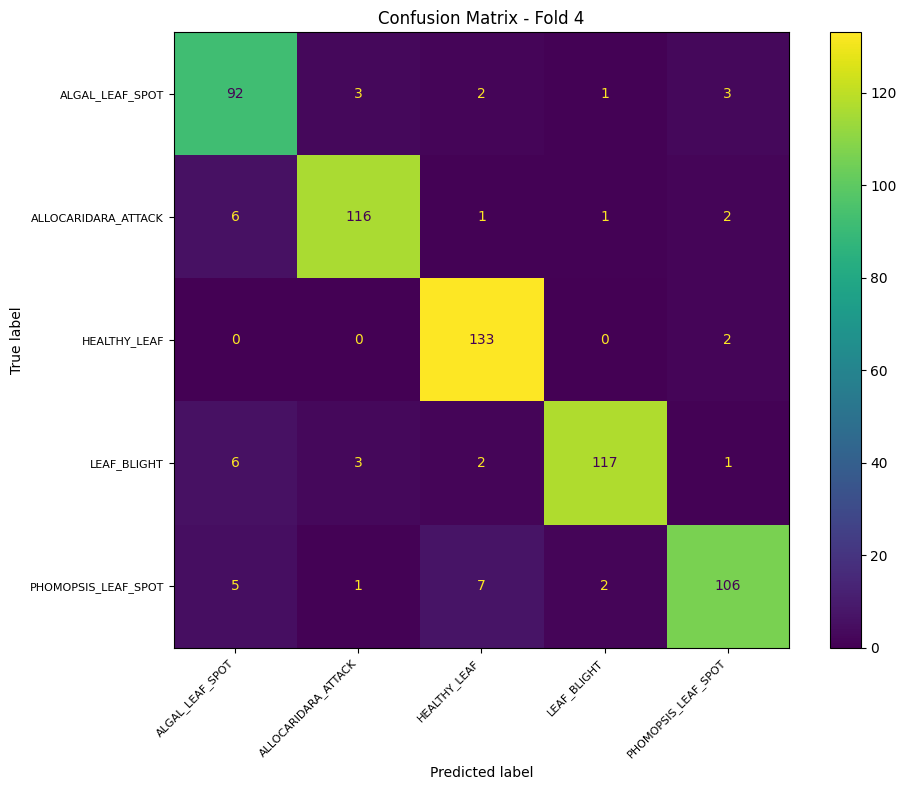

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.84      0.91      0.88       101
ALLOCARIDARA_ATTACK       0.94      0.92      0.93       126
       HEALTHY_LEAF       0.92      0.99      0.95       135
        LEAF_BLIGHT       0.97      0.91      0.94       129
PHOMOPSIS_LEAF_SPOT       0.93      0.88      0.90       121

           accuracy                           0.92       612
          macro avg       0.92      0.92      0.92       612
       weighted avg       0.92      0.92      0.92       612

--------------------------------------------------


In [28]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"mobilenetv3_large_100_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

## Visualization train model result

In [29]:
## Making Pridcition return class & prob
from typing import List, Tuple

from PIL import Image
def pred_class(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: T = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    classname =  class_names[target_image_pred_label]
    prob = target_image_pred_probs.max().cpu().numpy()

    return classname , prob

In [30]:
##Load some model
loaded_model = torch.load('mobilenetv3_large_100_checkpoint_fold0.pt', weights_only=False)

## Train data visulization

In [31]:
#Making df for rando
import os
import pandas as pd
from PIL import Image

# create an empty list to store image paths
image_paths = []

# loop through each subfolder in the "Image" directory
for root, dirs, files in os.walk("./../../data/test/"):
    for subfolder_name in dirs:
        # get the path to the subfolder
        subfolder_path = os.path.join(root, subfolder_name)
        # loop through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append((image_path, subfolder_name))

# create a DataFrame from the list of image paths
df = pd.DataFrame(image_paths, columns=['path', 'subfolder_name'])


In [32]:
df.head()

path   subfolder_name
0  ./../../data/test/ALGAL_LEAF_SPOT\to_label_104...  ALGAL_LEAF_SPOT
1  ./../../data/test/ALGAL_LEAF_SPOT\to_label_121...  ALGAL_LEAF_SPOT
2  ./../../data/test/ALGAL_LEAF_SPOT\to_label_123...  ALGAL_LEAF_SPOT
3  ./../../data/test/ALGAL_LEAF_SPOT\to_label_126...  ALGAL_LEAF_SPOT
4  ./../../data/test/ALGAL_LEAF_SPOT\to_label_128...  ALGAL_LEAF_SPOT

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



def sample_picture(df=df,random_state=None):
    # Sample 20 random rows from the DataFrame
    sample_df = df.sample(20, random_state=random_state).copy()
    sample_df = sample_df.reset_index(drop=True)
    # Define the grid layout for displaying the images
    num_rows = 4
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
    fig.tight_layout(pad=5.0)

    # Iterate over the sampled rows and display the images in the grid
    for i, row in sample_df.iterrows():
        img = Image.open(row['path'])

        # Prediction
        pred_name , prob = pred_class(model=loaded_model,image_path=row['path'],
                   class_names = classname,
                   transform=data_transforms["test"])

        row_idx = i // num_cols
        col_idx = i % num_cols
        axs[row_idx, col_idx].imshow(img)
        axs[row_idx, col_idx].axis('on')
        axs[row_idx, col_idx].set_title(row['subfolder_name'] + ': \nPredict:' + pred_name + '\nProb:'+ str(prob.round(decimals=2)) )

        # prediction


    plt.show()

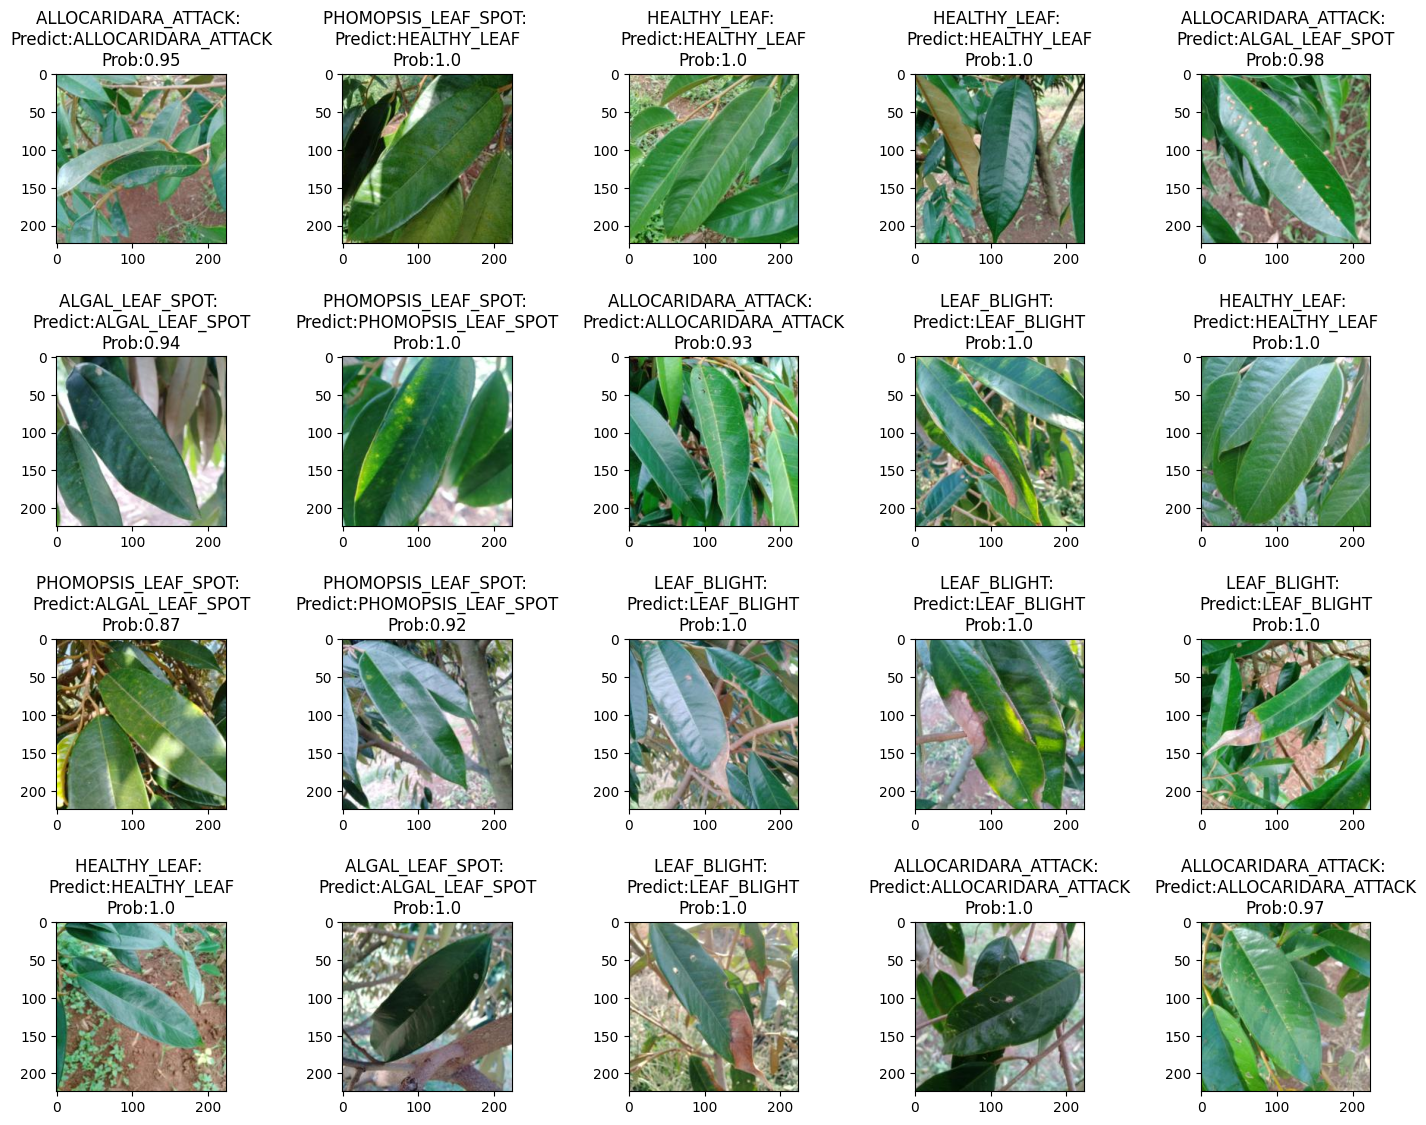

In [34]:
sample_picture()

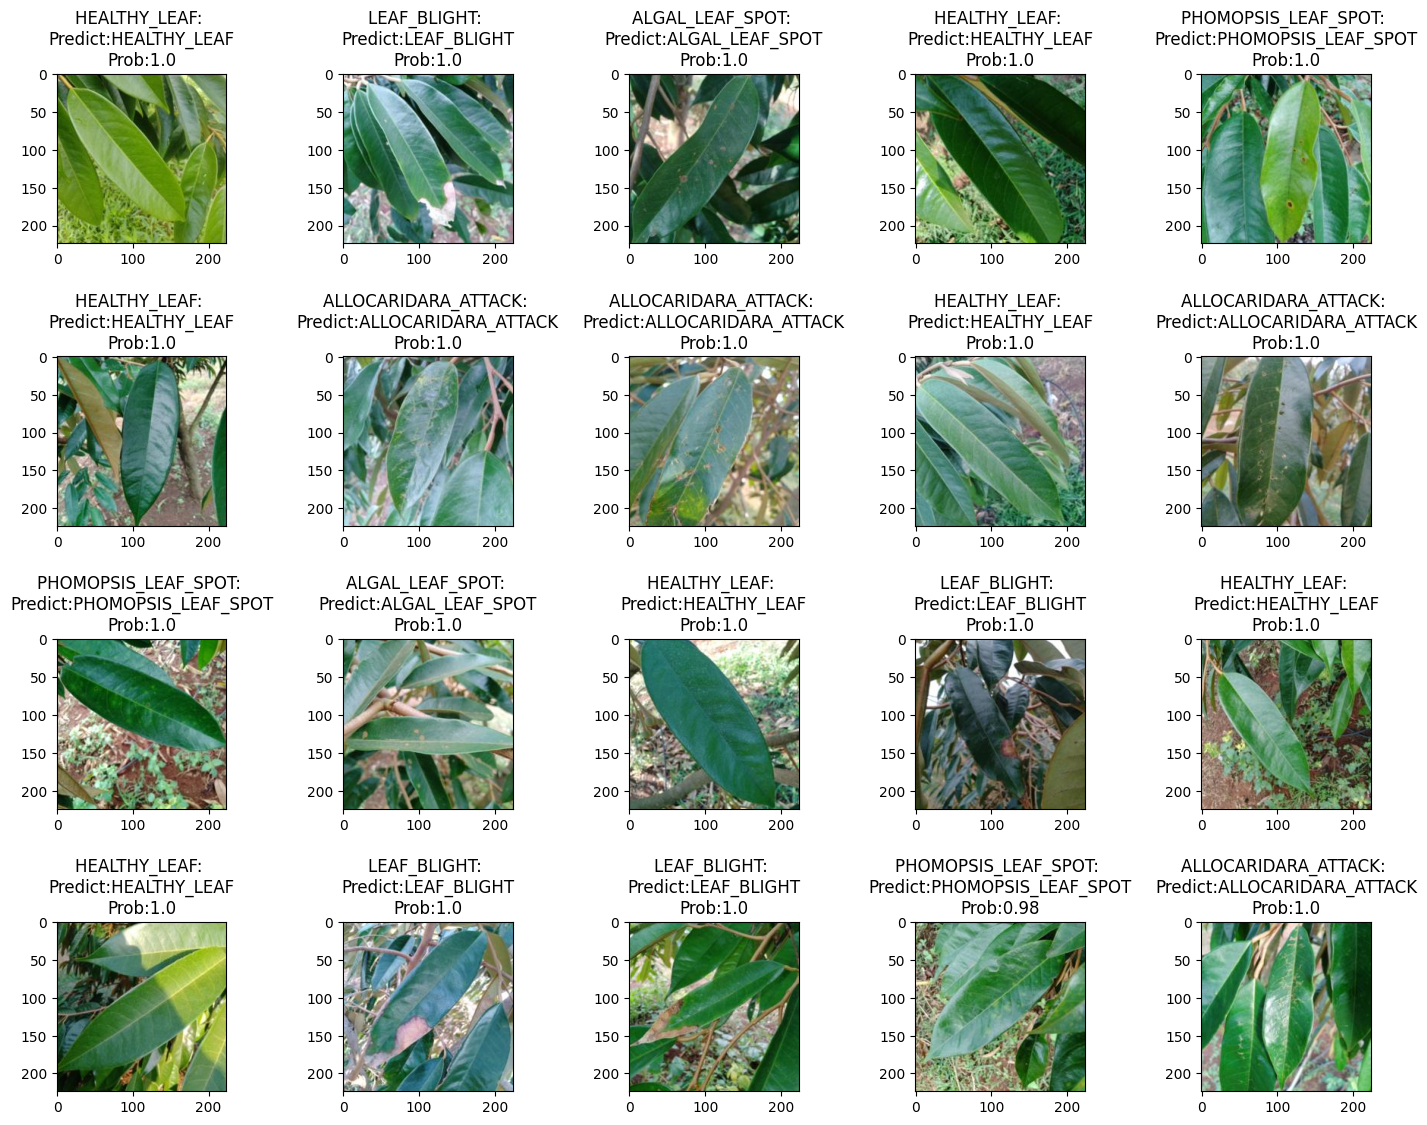

In [35]:
sample_picture()

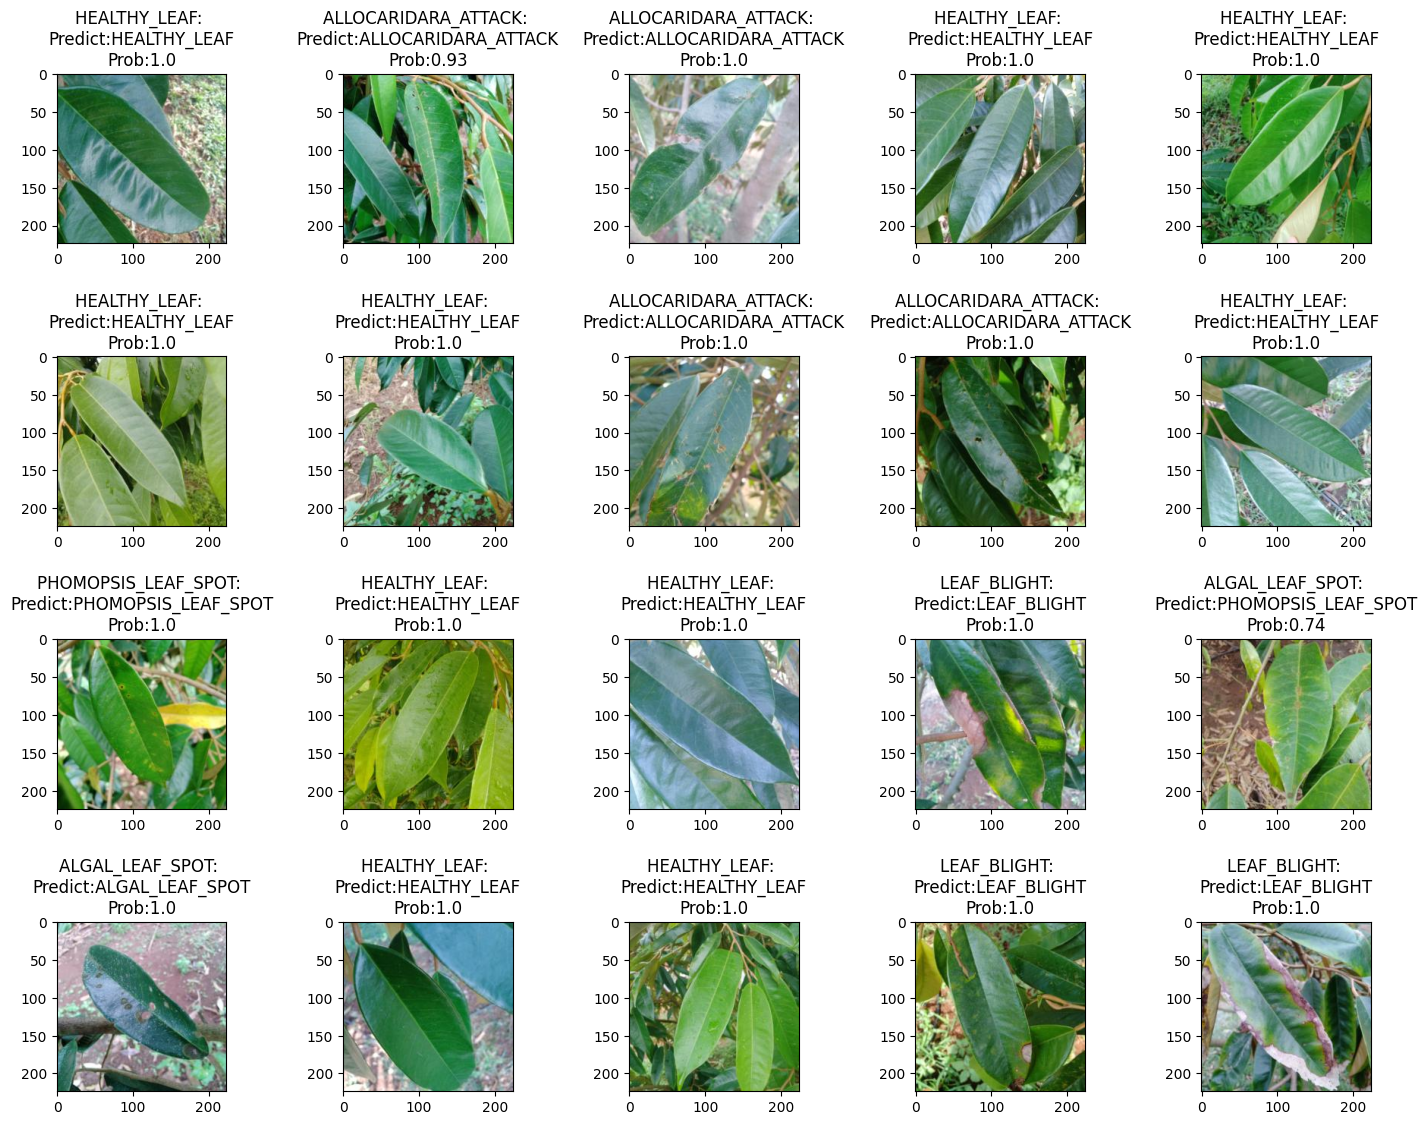

In [36]:
sample_picture()

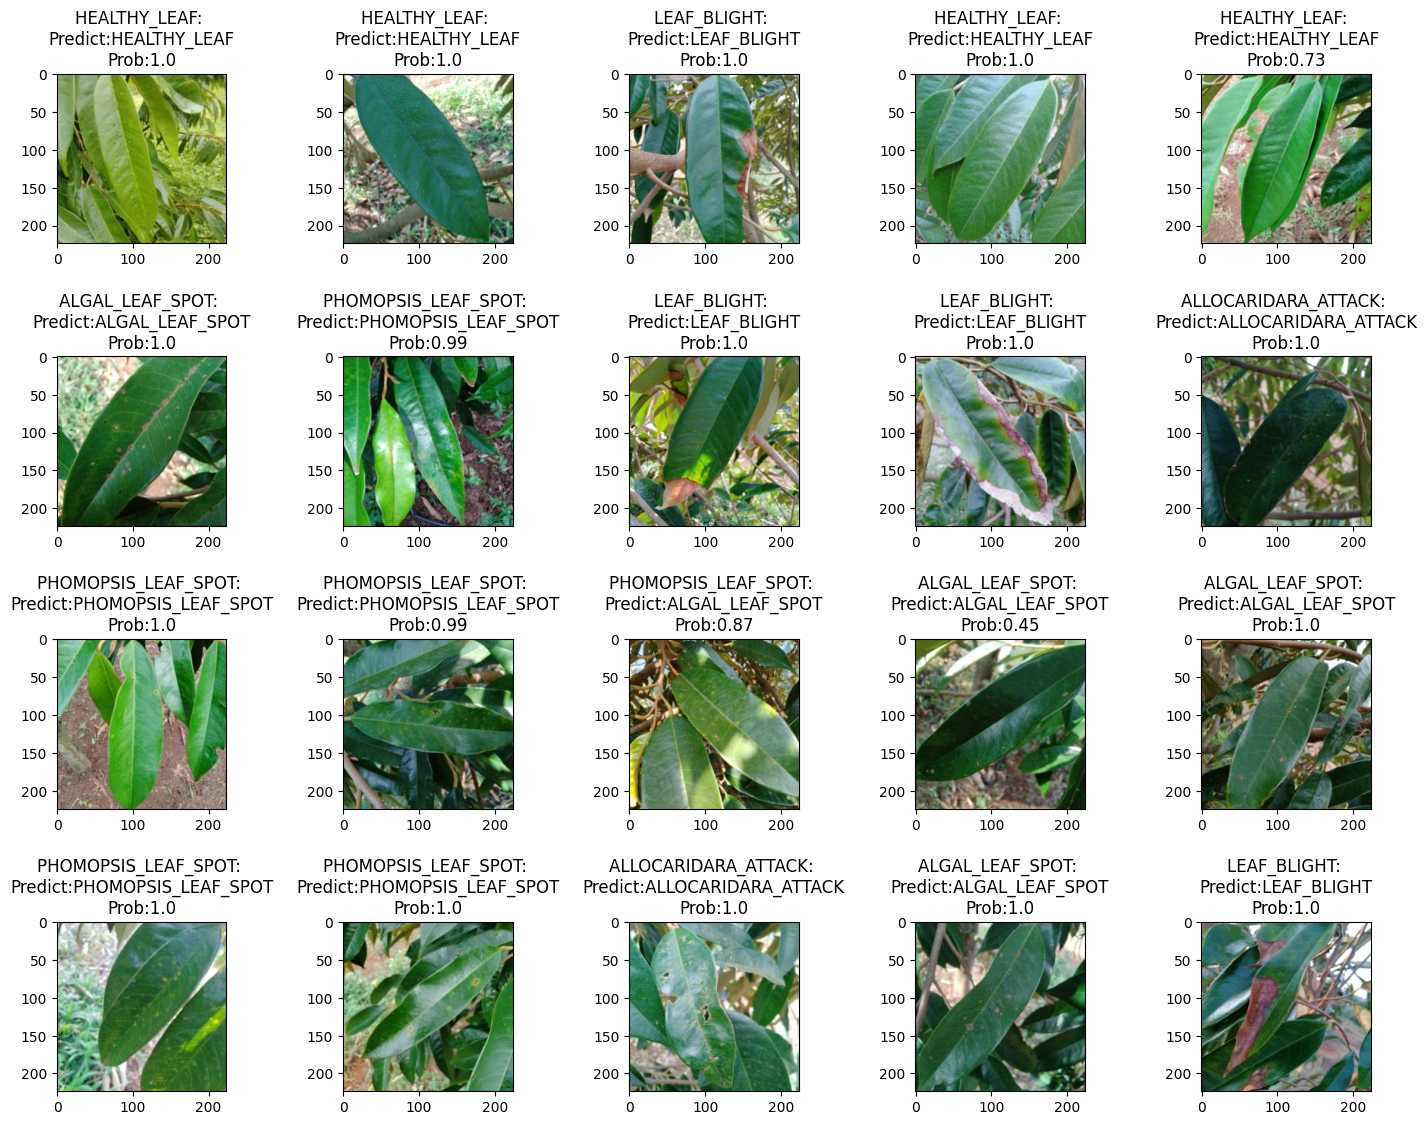

In [37]:
sample_picture()

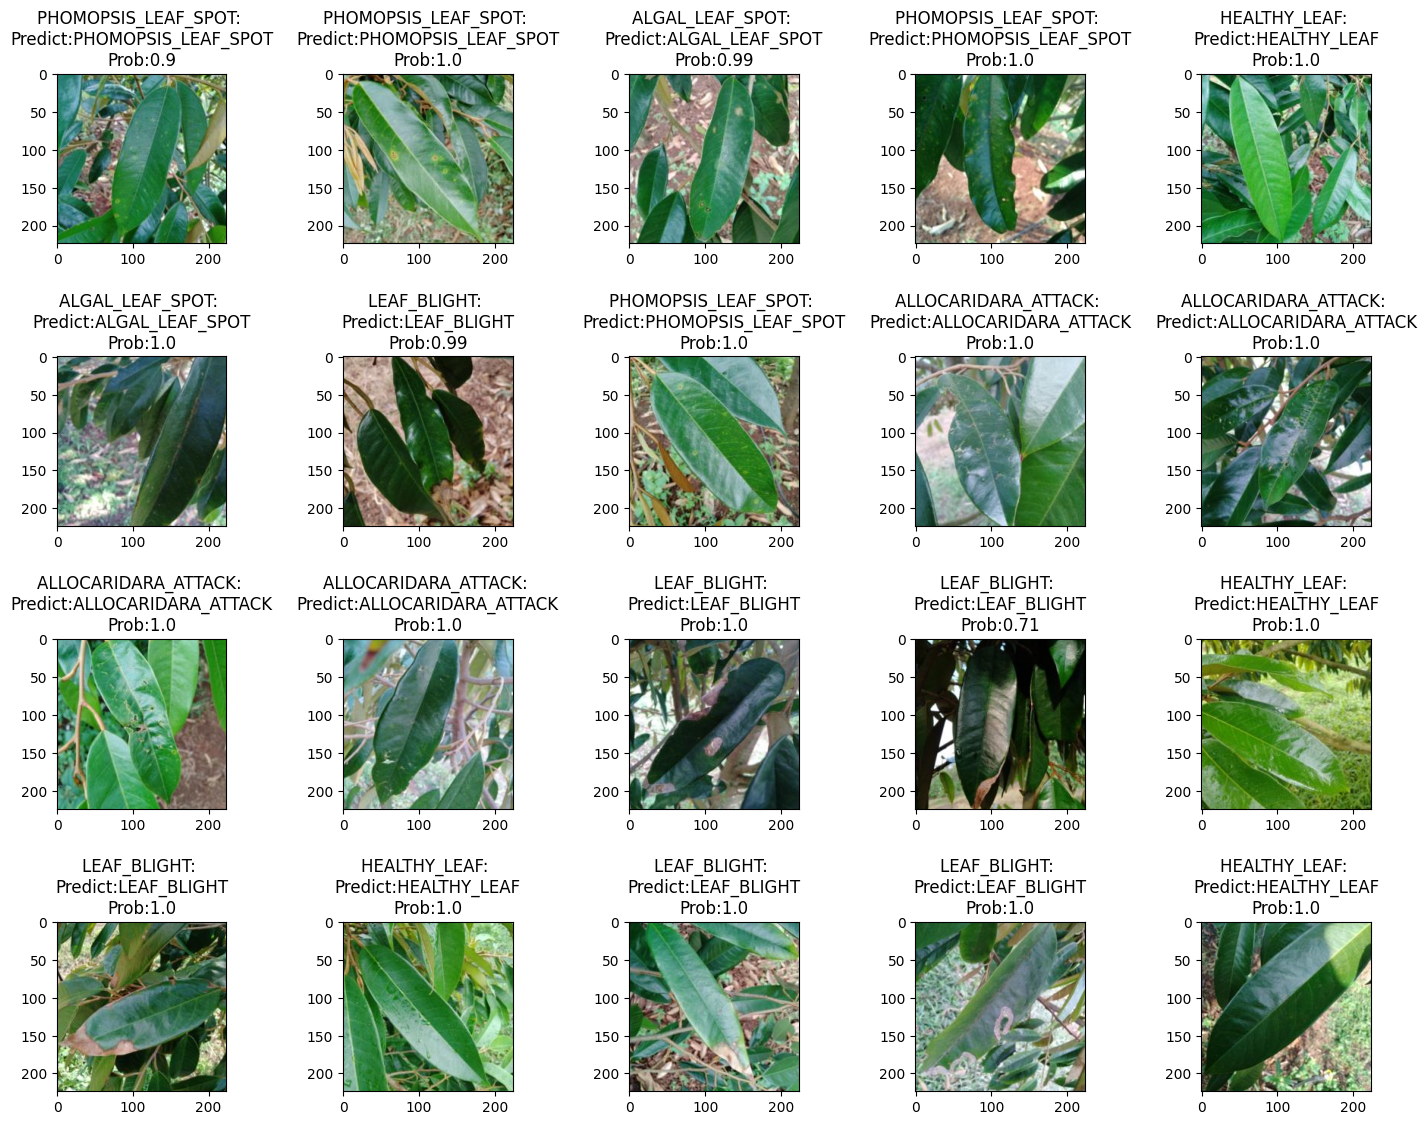

In [38]:
sample_picture()